In [1]:
import uproot as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from df_utils import * 
from global_settings import * 
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [2]:
run = "run3"
dm_type = "fermion"
mass = "0.05"
ratio = "0.6"
data = False
target_pot = 1.
signal_pot = {}
meson_correction_pi0 = meson_scalings["pi0"] 
meson_correction_eta = meson_scalings["eta"]

scalings_run1 = { "nu":1./2.35e21, "dirt":1.026*0.75/1.6e21, "beamoff": 0.98*(6230439.0/9186361.390000)}
scalings_run3 = { "nu":1./(1.993661e21), "dirt":1.0*0.35/1.020e21, "beamoff": 0.98*(10710362.0/34147459.925000)}

scalings = {}

if(run == "run1"):
    run_flag = "Run 1"
    target_pot = 2.384e+20
    scalings = scalings_run1
    pot_label = r'                    $2.38\times10^{20}$ POT'
else:
    run_flag = "Run 3"
    target_pot = 5.182e20
    scalings = scalings_run3
    pot_label = r'                    $5.18\times10^{20}$ POT'



In [3]:
base_dir = "/home/lmlepin/Desktop/dm_sets/dark_tridents_analysis/" + run + "_samples/" 
signal_dir = "/home/lmlepin/Desktop/dm_sets/dark_tridents_analysis/" + run + "_signal/"
plots_dir = "/home/lmlepin/Desktop/Plots_DT_Drive/2023/data_mc/"

df_signal = pd.read_csv(signal_dir + "{}_dt_ratio_{}_{}_pi0_CNN_scores_8441_steps.csv".format(run,ratio,mass))
df_nu = pd.read_csv(base_dir + run + "_nu_overlay_CNN_scores_8441_steps.csv")
df_dirt = pd.read_csv(base_dir + run + "_dirt_CNN_scores_8441_steps.csv")
df_offbeam = pd.read_csv(base_dir + run + "_offbeam_CNN_scores_8441_steps.csv")
df_beamon = pd.read_csv(base_dir + run + "_beamon_CNN_scores_8441_steps.csv")


df_signal = df_signal.drop_duplicates()
df_nu = df_nu.drop_duplicates()
df_dirt = df_dirt.drop_duplicates()
df_offbeam = df_offbeam.drop_duplicates()
df_beamon = df_beamon.drop_duplicates()

signal_fraction = len(df_signal)/len(df_signal[df_signal['signal_score']>= 0.])
nu_fraction = len(df_nu)/len(df_nu[df_nu['signal_score']>= 0.])
dirt_fraction = len(df_dirt)/len(df_dirt[df_dirt['signal_score'] >= 0.])
beamoff_fraction = len(df_offbeam)/len(df_offbeam[df_offbeam['signal_score'] >= 0.])
beamon_fraction = len(df_beamon)/len(df_beamon[df_beamon['signal_score'] >= 0.])


print("Nu fraction: ", nu_fraction)
print("Dirt fraction: ", dirt_fraction)
print("beam-off fraction: ", beamoff_fraction)
print("beamon-on fraction: ", beamon_fraction)

# Note that by dividing by the beamon_fraction we are taking into account the events that
# are lost due to failed jobs in larcv 

signal_scaling = (signal_fraction*meson_correction_pi0*target_pot/df_signal['total_pot'][0])
nu_scaling = target_pot*scalings["nu"]*(nu_fraction)/(beamon_fraction)
dirt_scaling = target_pot*scalings["dirt"]*(dirt_fraction)/(beamon_fraction)
offbeam_scaling = scalings["beamoff"]*(beamoff_fraction)/(beamon_fraction)


multisim_uncertainty = 0.2 
detvars_uncertainty = 0.3
dirt_uncertainty = 0.5 



MC_weight_branch(df_nu)
MC_weight_branch(df_dirt)

Nu fraction:  1.0006073752711497
Dirt fraction:  1.0004145936981759
beam-off fraction:  1.0489084666709854
beamon-on fraction:  1.0826809504188986


In [4]:
def logit_transform(score):
    return np.log(score/(1-score))

def filter_df(df):
    df = df[df['signal_score'] >= 0.5]
    return df 

def GetStatsUncert(df_a, weight_array,my_custom_bins,plot_var):
    (counts_df, bins_df) = np.histogram(df_a[plot_var], bins = my_custom_bins, weights=np.square(weight_array))
    return counts_df

Showing results for: run3
Number of dark tridents M_A=0.05 :185.41711705348035
Number of neutrinos: 2641.062882796261
Number of dirt: 385.1110763282181
Number of beam-off: 4596.971604714715
Number of beam-on: 7281


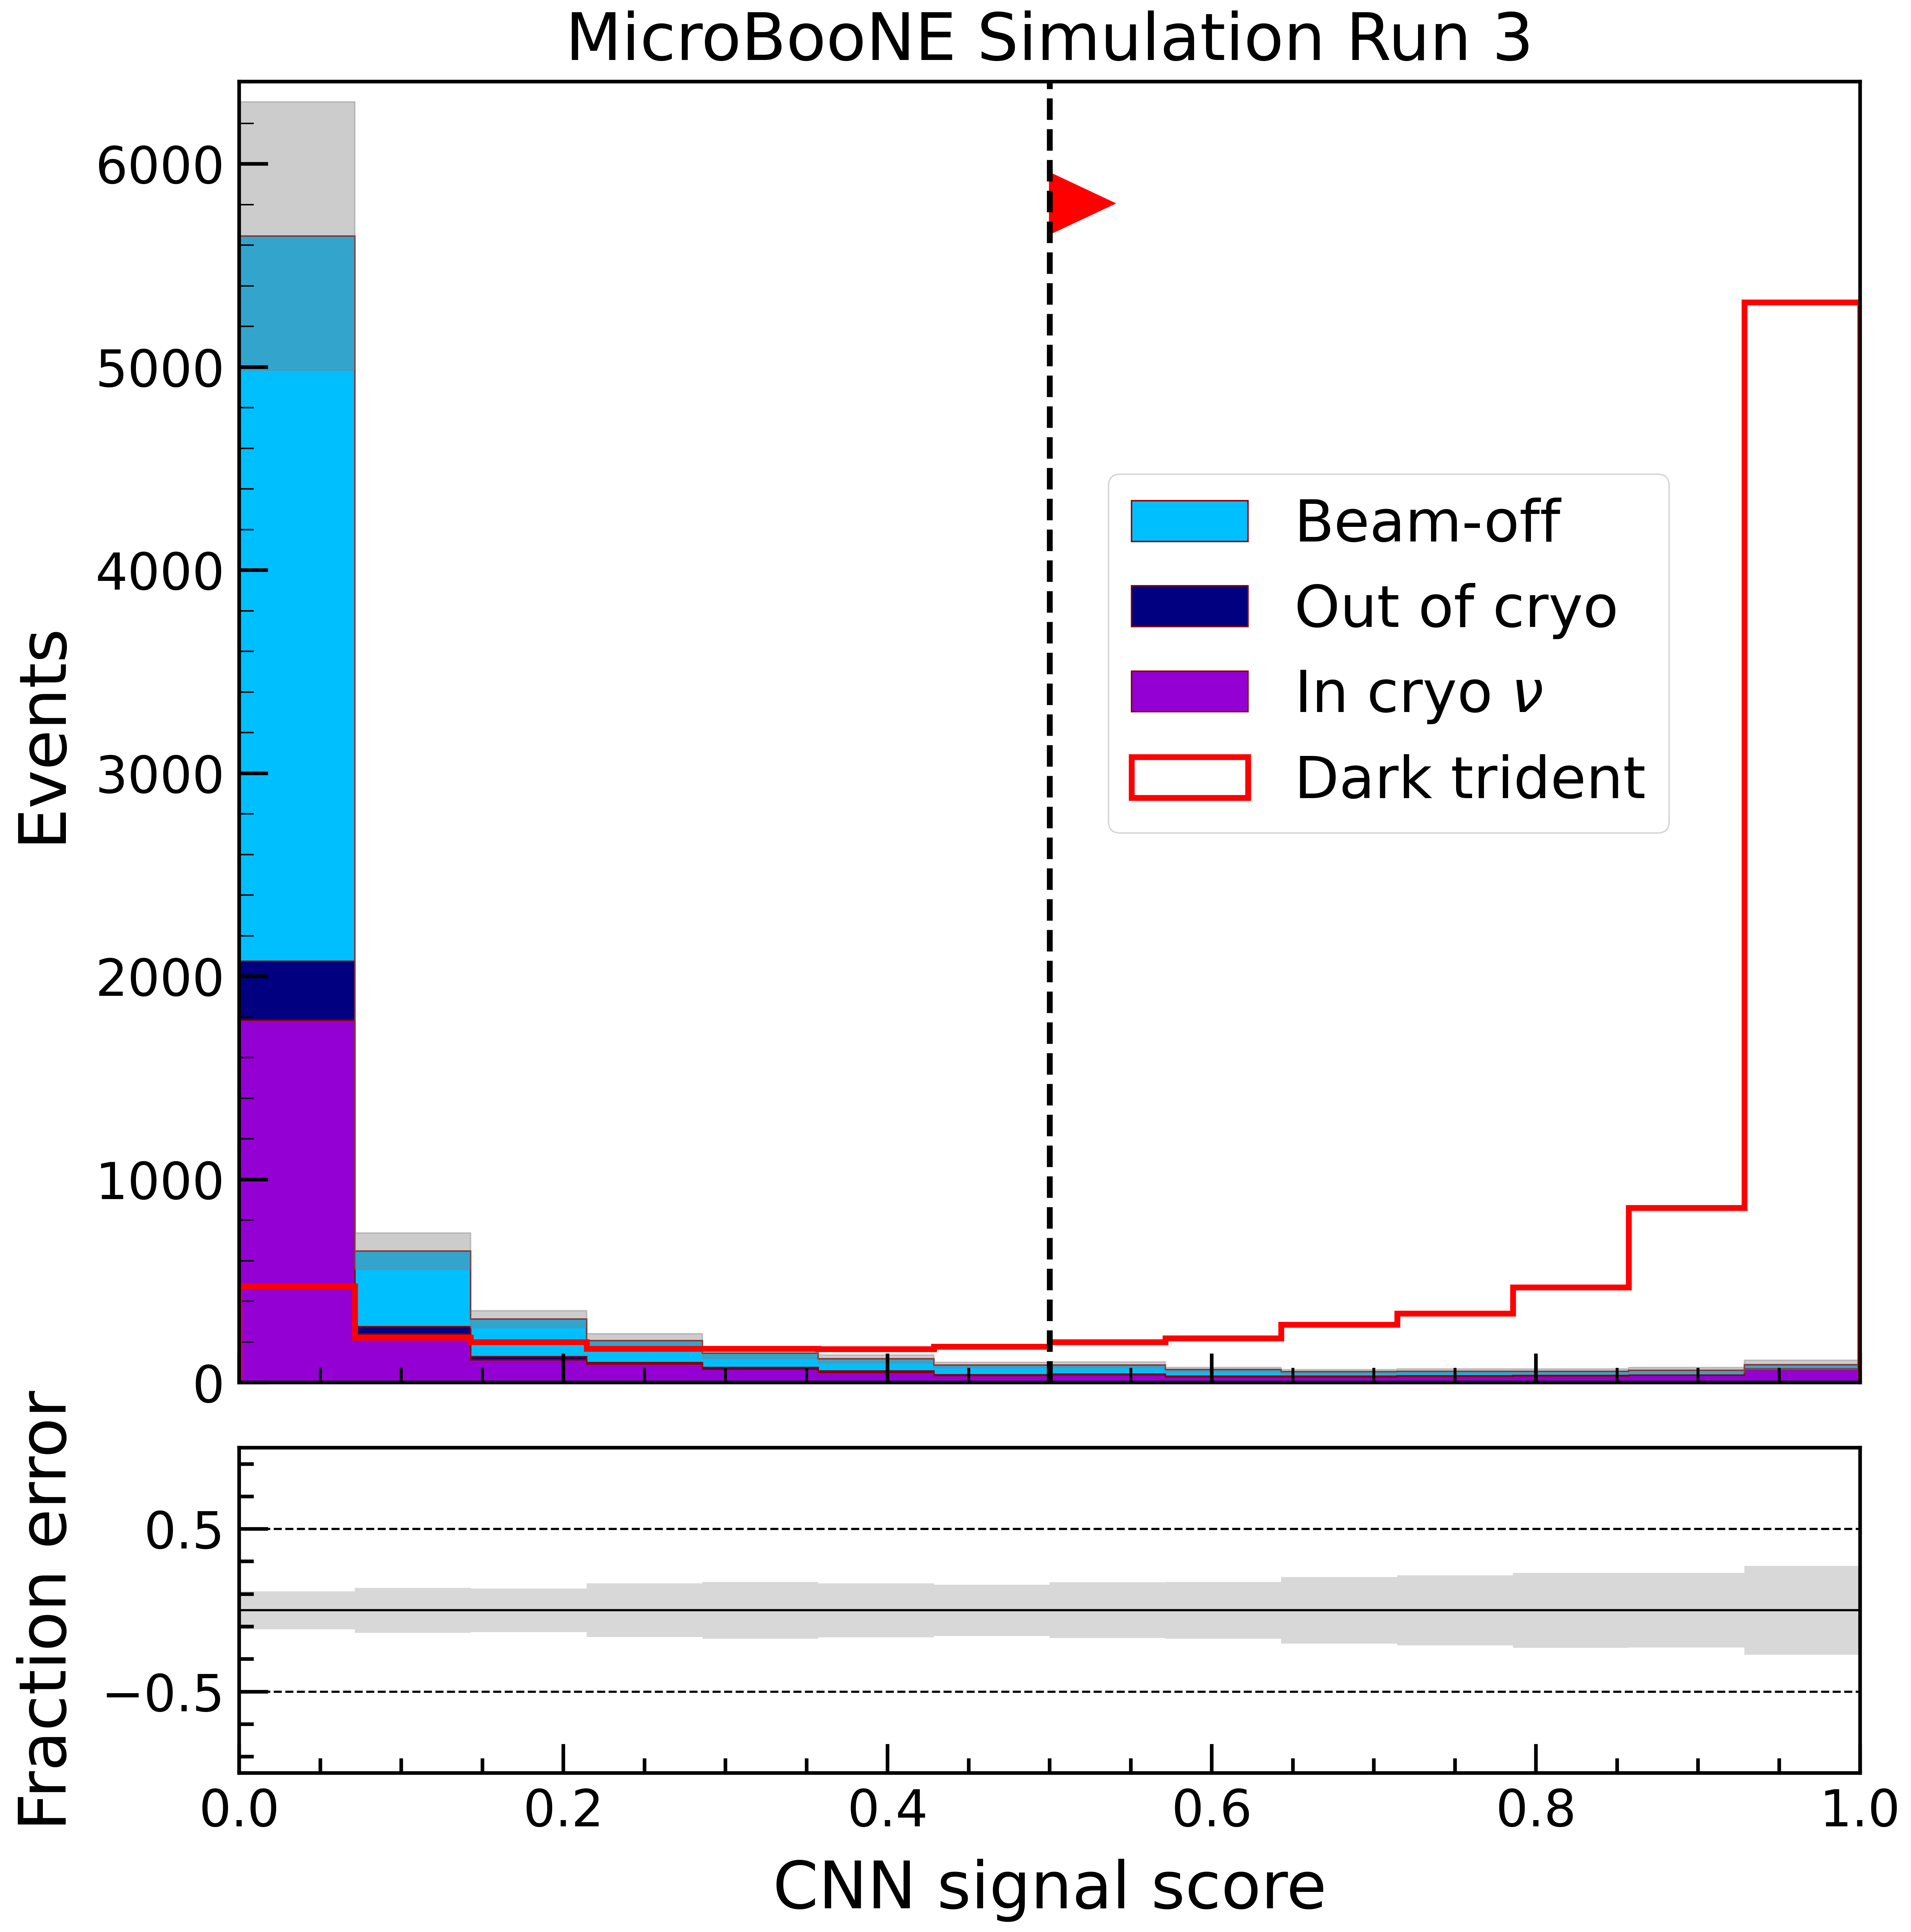

In [5]:
#my_custom_bins = [ 0., 1.375, 2.75, 4.125, 5.5, 11.] # Last four bins merged bc of low stats
my_custom_bins = np.linspace(0.,1.,15)
variable = 'signal_score'
up_plot = 1.
down_plot = 0.


(counts_signal, bins_signal) = np.histogram(df_signal[variable], bins = my_custom_bins)
(counts_nu, bins_nu) = np.histogram(df_nu[variable], bins = my_custom_bins, weights = df_nu['weight'])
(counts_dirt, bins_dirt) = np.histogram(df_dirt[variable], bins = my_custom_bins, weights = df_dirt['weight'])
(counts_offbeam, bins_offbeam) = np.histogram(df_offbeam[variable], bins = my_custom_bins)
(counts_beamon, bins_beamon) = np.histogram(df_beamon[variable], bins = my_custom_bins)

print("Showing results for: " + run)
print("Number of dark tridents M_A="+str(mass)+" :" + str(np.sum(counts_signal)*signal_scaling))
print("Number of neutrinos: " + str(np.sum(counts_nu)*nu_scaling))
print("Number of dirt: " + str(np.sum(counts_dirt)*dirt_scaling))
print("Number of beam-off: " + str(np.sum(counts_offbeam)*offbeam_scaling))
print("Number of beam-on: " + str(np.sum(counts_beamon)))

# Set plot specs with patches!!!

dt_legend = r'Dark trident'
nu_legend = r'In cryo $\nu$'
dirt_legend = r'Out of cryo'
beamoff_legend = r'Beam-off'
beamon_legend = r'NuMI data'

stacked_colors = ["darkviolet","navy","deepskyblue"]
stacked_legend = [nu_legend, dirt_legend, beamoff_legend]
stacked_bins = [bins_nu[:-1], bins_dirt[:-1], bins_offbeam[:-1]]
stacked_list = [counts_nu*nu_scaling, counts_dirt*dirt_scaling, counts_offbeam*offbeam_scaling ]


# Getting stats error 
counts_bkg = counts_nu*nu_scaling + counts_dirt*dirt_scaling + counts_offbeam*offbeam_scaling
stats_nu = GetStatsUncert(df_nu, df_nu['weight']*nu_scaling,my_custom_bins,variable)
stats_dirt = GetStatsUncert(df_dirt, df_dirt['weight']*dirt_scaling,my_custom_bins,variable)
stats_beamoff = GetStatsUncert(df_offbeam, np.ones(len(df_offbeam))*offbeam_scaling,my_custom_bins,variable)
stats_total = np.sqrt(stats_nu + stats_dirt + stats_beamoff)

nu_CV = (counts_nu*nu_scaling)
dirt_CV = (counts_dirt*dirt_scaling)
sigma_detvar = nu_CV*detvars_uncertainty
sigma_multisim = nu_CV*multisim_uncertainty
sigma_mc_dirt = dirt_CV*dirt_uncertainty

sigma_nu = np.sqrt(stats_nu + sigma_detvar**2 + sigma_multisim**2)
sigma_dirt = np.sqrt(stats_dirt + sigma_mc_dirt**2)
sigma_beamoff = np.sqrt(stats_beamoff)


total_error_mc = np.sqrt(sigma_nu**2 + sigma_dirt**2 + sigma_beamoff**2)
stats_error = (stats_total)/(counts_bkg)
stats_up = counts_bkg + total_error_mc
stats_down = counts_bkg - total_error_mc

# Trick for right error band on histograms 
bins_err = np.copy(bins_nu)
bins_err = np.append(bins_err,[bins_err[-1] + (bins_err[2] - bins_err[1])])
stats_up = np.append(stats_up,[stats_up[-1],stats_up[-1] ])
stats_down = np.append(stats_down,[stats_down[-1],stats_up[-1]])


fig, ax = plt.subplots(2,1,figsize=(20,21),dpi=300,gridspec_kw={'height_ratios': [4, 1], 'hspace': 0.08})

for axis in ['top', 'bottom', 'left', 'right']:
    ax[0].spines[axis].set_linewidth(2.5)  # change width
    ax[0].spines[axis].set_color('black')    # change color
    
for axis in ['top', 'bottom', 'left', 'right']:
    ax[1].spines[axis].set_linewidth(2.5)  # change width
    ax[1].spines[axis].set_color('black')    # change color


ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())  

    
ax[0].set_title(r'MicroBooNE Simulation' + ' ' + run_flag,fontsize=45,pad=15)   
ax[0].hist(stacked_bins, bins = bins_nu, weights = stacked_list, histtype='stepfilled',stacked=True, color = stacked_colors, edgecolor="darkred", label = stacked_legend)
ax[0].fill_between(bins_err, stats_up, stats_down,color='gray',alpha=0.4,step='post')
if(data):
    ax[0].set_title(r'MicroBooNE NuMI data' + ' ' + run_flag + "        "+ pot_label ,fontsize=45,pad=15)
    ax[0].errorbar(bins_nu[:-1]+ 0.5*(bins_nu[1:] - bins_nu[:-1]),counts_beamon,yerr=np.sqrt(counts_beamon),fmt='o',markersize=12, capsize=15, color='black',label=beamon_legend)
ax[0].hist(bins_signal[:-1], bins = bins_signal,weights=counts_signal*signal_scaling*50, histtype='step',label=dt_legend ,fill=False, edgecolor='red', linewidth=4)

#vertical line with arrow
ax[0].vlines(0.5, 0., stats_up[0]+100, color='black',linestyle='--',linewidth=4)
ax[0].arrow(0.5, stats_up[0]-500, 0.02, 0,color='red',head_width=300,head_length=0.04,length_includes_head=True,head_starts_at_zero=True)


ax[0].legend(fontsize=40,loc='lower right',bbox_to_anchor=[0.9,0.4])#bbox_to_anchor=[0.5,0.7])
ax[0].tick_params(axis="y", which='major', direction="in",length=20,width=2.5,pad=10, labelsize=35)
ax[0].tick_params(axis="y", which='minor', direction="in",length=10,width=1.0,labelleft=False, labelsize=35)
ax[0].tick_params(axis="x", which='major', direction="in",length=20,width=2.5,pad=10, bottom=True,top=False,labelbottom=False)
ax[0].tick_params(axis="x", which='minor', direction="in",length=10,width=2.0, bottom=True,top=False,labelbottom=False)
ax[0].set_xlim(down_plot,up_plot)
ax[0].set_ylim(0.,stats_up[0]+100)
ax[0].set_ylabel("Events",fontsize=45, labelpad=15) 

total_pred = (counts_nu*nu_scaling + counts_dirt*dirt_scaling + counts_offbeam*offbeam_scaling )
ratio = (counts_beamon - total_pred)/(total_pred)

subs_error = np.sqrt( counts_beamon + stats_total**2)

total_error = np.abs(ratio)*np.sqrt( (subs_error/(counts_beamon - total_pred))**2 + (stats_total/total_pred)**2)

if(data):
    ax[1].errorbar(bins_nu[:-1]+ 0.5*(bins_nu[1:] - bins_nu[:-1]),ratio,yerr=total_error,fmt='o',markersize=12,capsize=15,color='black')
ax[1].hist(bins_beamon[:-1], bins = bins_beamon,weights=total_error_mc/counts_bkg,histtype='stepfilled',color='gray',alpha=0.3,lw=2)
ax[1].hist(bins_beamon[:-1], bins = bins_beamon,weights=-1*total_error_mc/counts_bkg,histtype='stepfilled',color='gray',alpha=0.3,lw=2)
ax[1].hlines(0.,down_plot,up_plot,color='black',linewidth=1.5)
ax[1].hlines(-0.5,down_plot,up_plot,color='black',linestyle="--",linewidth=1.5)
ax[1].hlines(0.5,down_plot,up_plot,color='black',linestyle="--",linewidth=1.5)
ax[1].tick_params(axis='both', which='major',direction="in", length=20, width=2.5, labelsize=35,pad=10)
ax[1].tick_params(axis='both', which='minor',direction="in", length=10, width=2.5, labelsize=35,pad=10)
ax[1].set_yticks([-0.5,0.5])
ax[1].set_ylim(-1.,1.)
ax[1].set_xlabel(r'CNN signal score',fontsize=45,labelpad=15)
ax[1].set_xlim(down_plot,up_plot)
ax[1].set_ylabel(r'Fraction error',fontsize=45,labelpad=15)
if(data):
    ax[1].set_ylabel(r'(D - P)/P',fontsize=40,labelpad=15)
    plt.savefig(plots_dir + "data_mc_comparison_" + run + "_" + variable + "_no_logit_transformation.png",bbox_inches="tight")
else:
    plt.savefig(plots_dir + "CNN_distribution_" + run + "_" + variable + "_no_logit_transformation.pdf",bbox_inches="tight")
    plt.savefig(plots_dir + "CNN_distribution_" + run + "_" + variable + "_no_logit_transformation.png",bbox_inches="tight")
plt.show()